## Compositional Lotka Volterra and ALR transformation on c. diff. dataset (original counts)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import torch
import math

from compositional_lotka_volterra_alr import *

# Import dataset

### Read data

In [4]:
# function to import the datafile and put it into the right format
def create_data():
    ts_all = []
    data_all = []
    names_all = []
    for sub in np.arange(5):
        # path of data file
        filename_tmp = f"ts_bucci_subject_{sub+1}_rel_counts_most_abundant.csv"
        filepath_tmp = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/" + filename_tmp
        data = pd.read_csv(filepath_tmp, sep=",", header=0)
        names = list(data.columns)[1:]
        usol = data.to_numpy()
        ts = usol[:, 0]
        data_y = usol[:, 1:]
        ts_all.append(ts)
        data_all.append(data_y)
        names_all.append(names)
        print(f"shape of Bucci Subject {sub+1}", data_y.shape)
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    return ts_all, data_all, names_all

In [5]:
T, Y, Names = create_data()

shape of Bucci Subject 1 (26, 14)
shape of Bucci Subject 2 (26, 14)
shape of Bucci Subject 3 (26, 14)
shape of Bucci Subject 4 (26, 14)
shape of Bucci Subject 5 (26, 14)


In [6]:
# set dimensions of the dataset
n_samples, n_taxa = Y[0].shape

n_subjects = 5

In [7]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [8]:
Y = adjust_concentrations(Y) 
P = []
Y_pc = []
log_Y = []
i = 0
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)
    i += 1

### Plot data

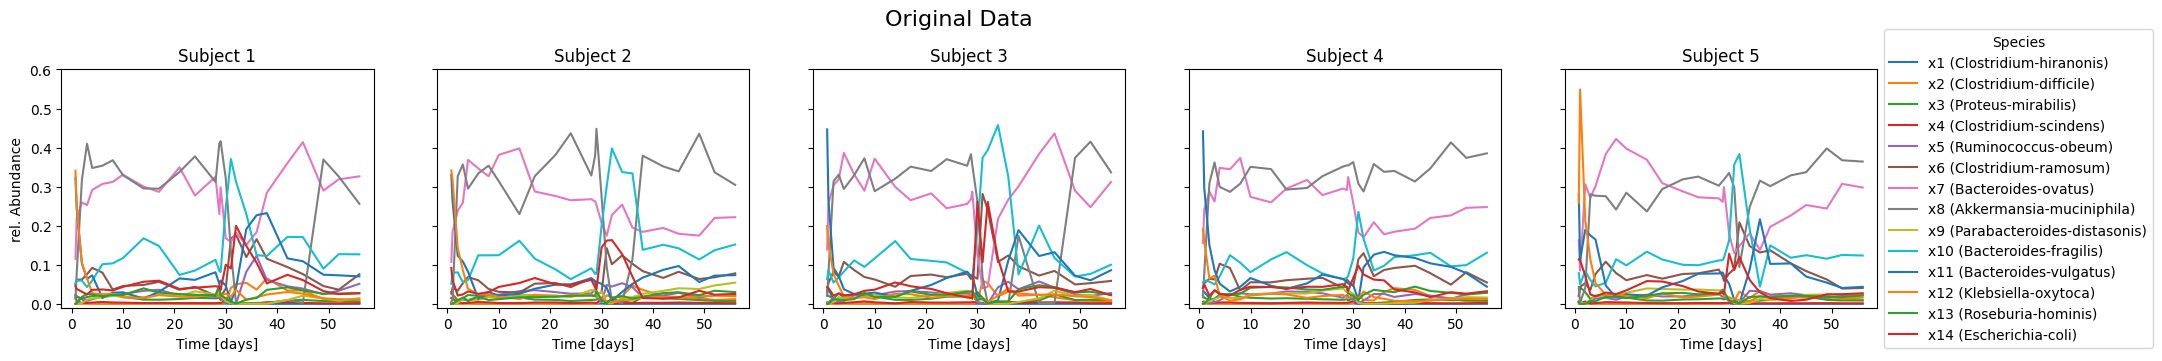

In [9]:
# plot P for all subjects
fig, axs = plt.subplots(1, n_subjects)
fig.set_figwidth(19)
fig.set_figheight(3.5)
fig.suptitle("Original Data",
             size = 16)
fig.tight_layout(pad=1.5)
for sub in np.arange(n_subjects):
    for i in np.arange(n_taxa):
        axs[sub].plot(T[sub], P[sub][:,i], label = f"x{i} ({Names[sub][i]})")
    # ax[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[sub].set_title(f"Subject {sub+1}")

for ax in axs.flat:
    ax.set_ylim(-0.01, 0.6)
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("rel. Abundance")
    ax.label_outer()

axs[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Species")
plt.show()
# plt.savefig('../../../Plots/bucci_data_original_fiveSubjects_noLegend.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [10]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

In [11]:
choose_denom(P)

6

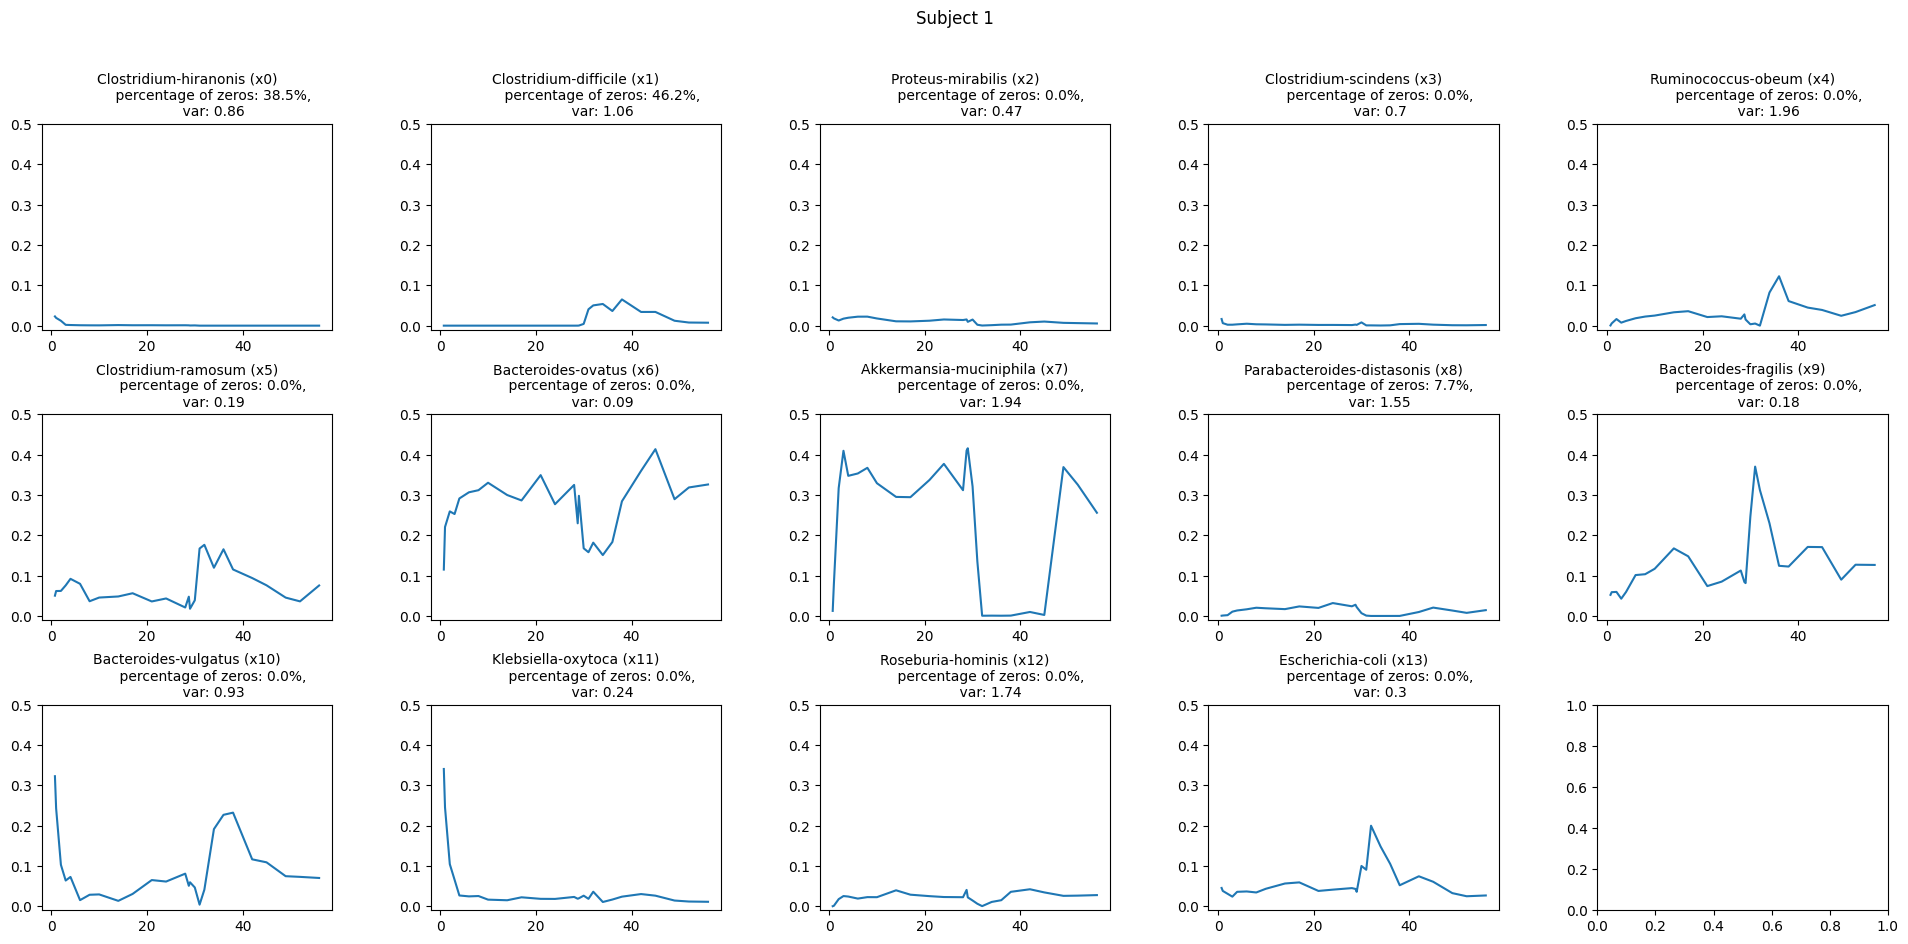

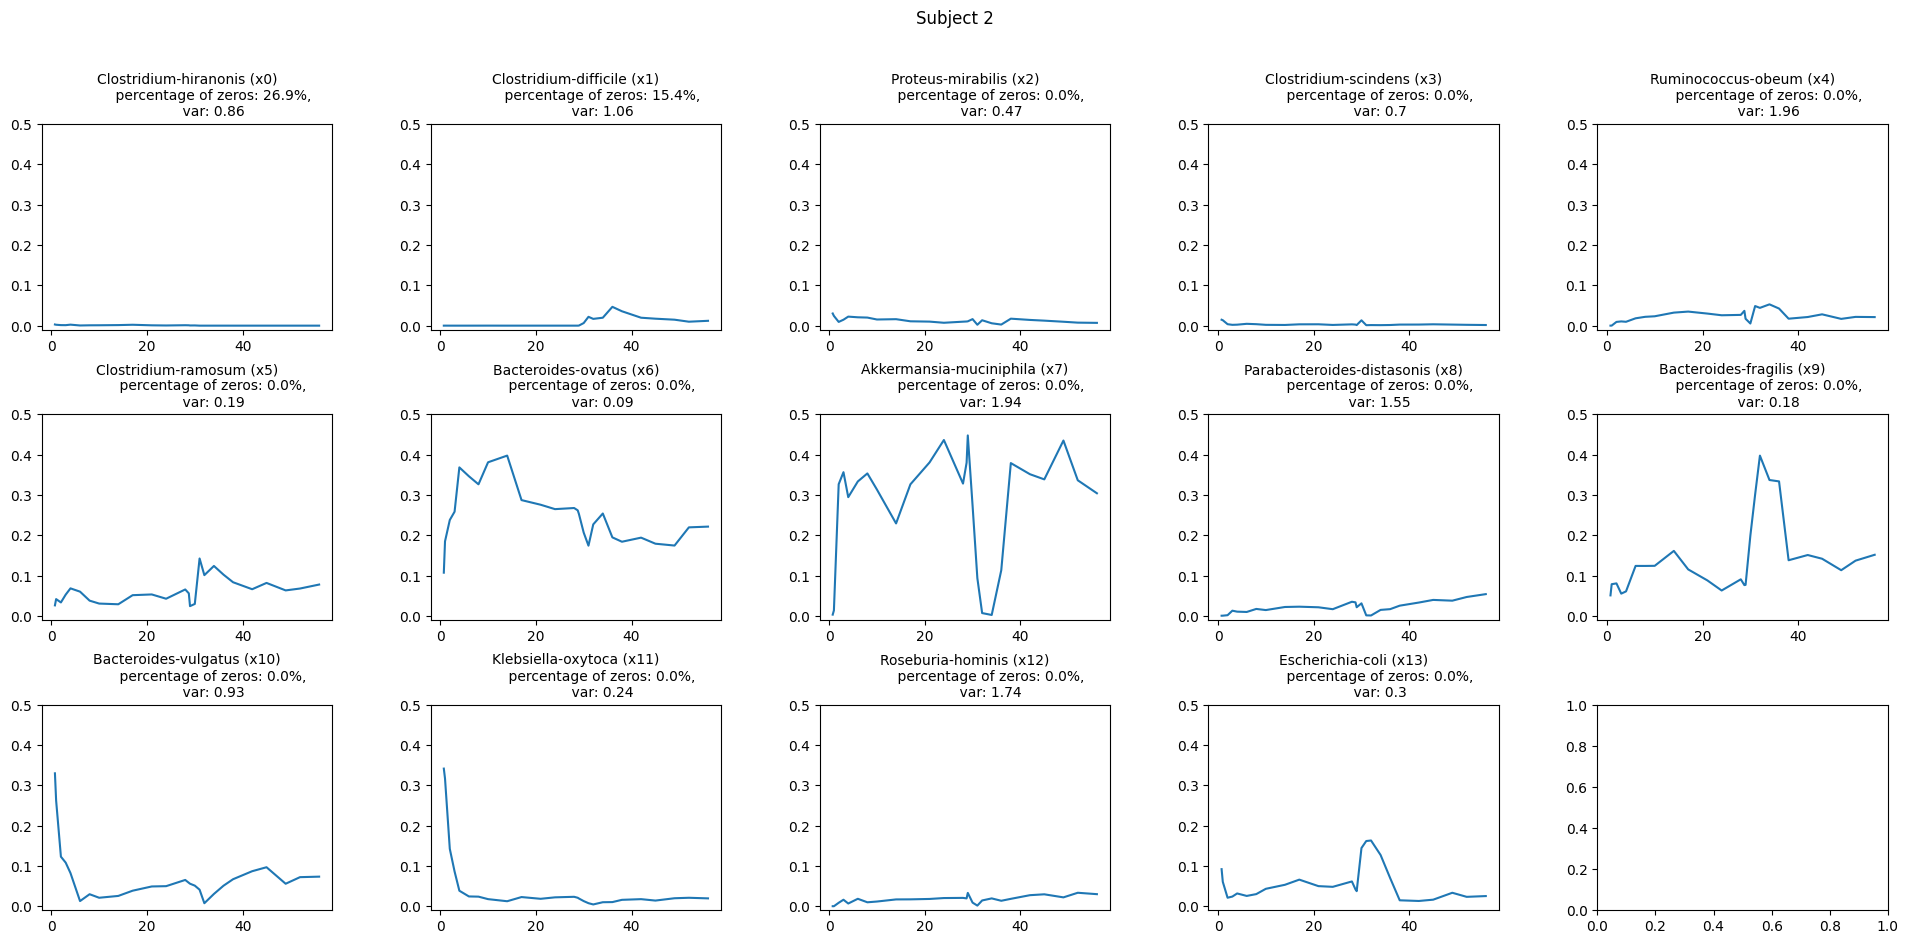

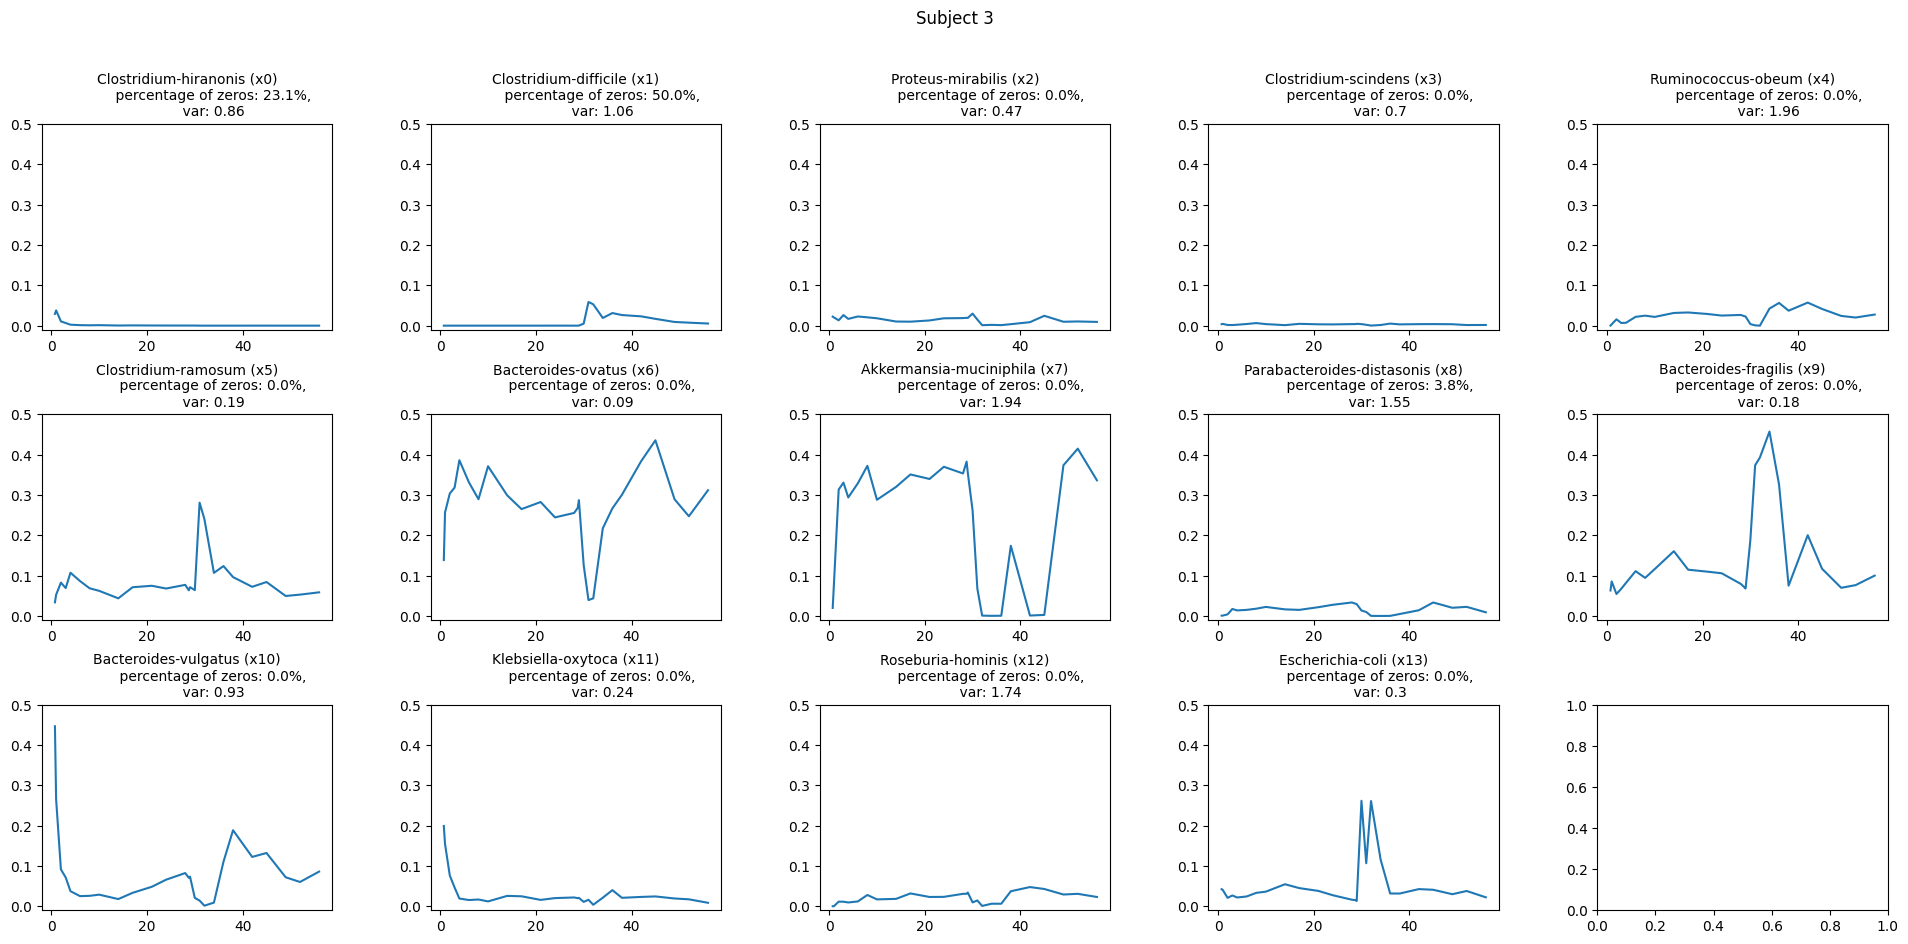

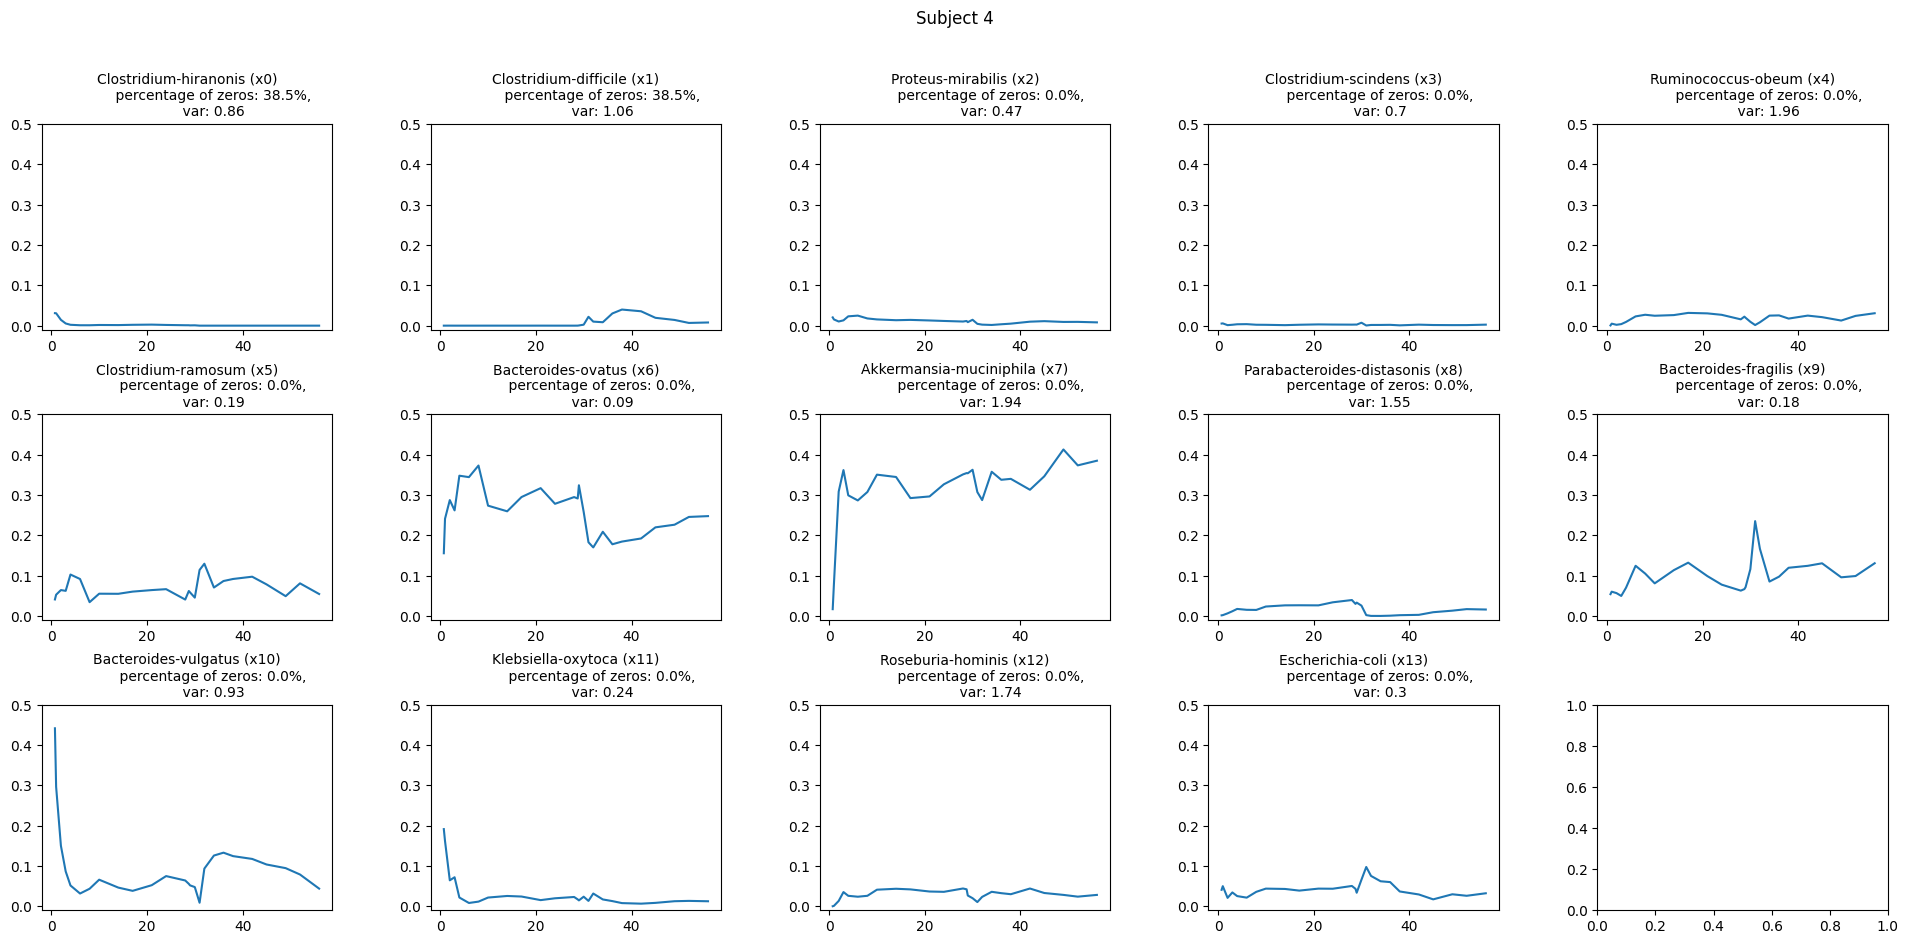

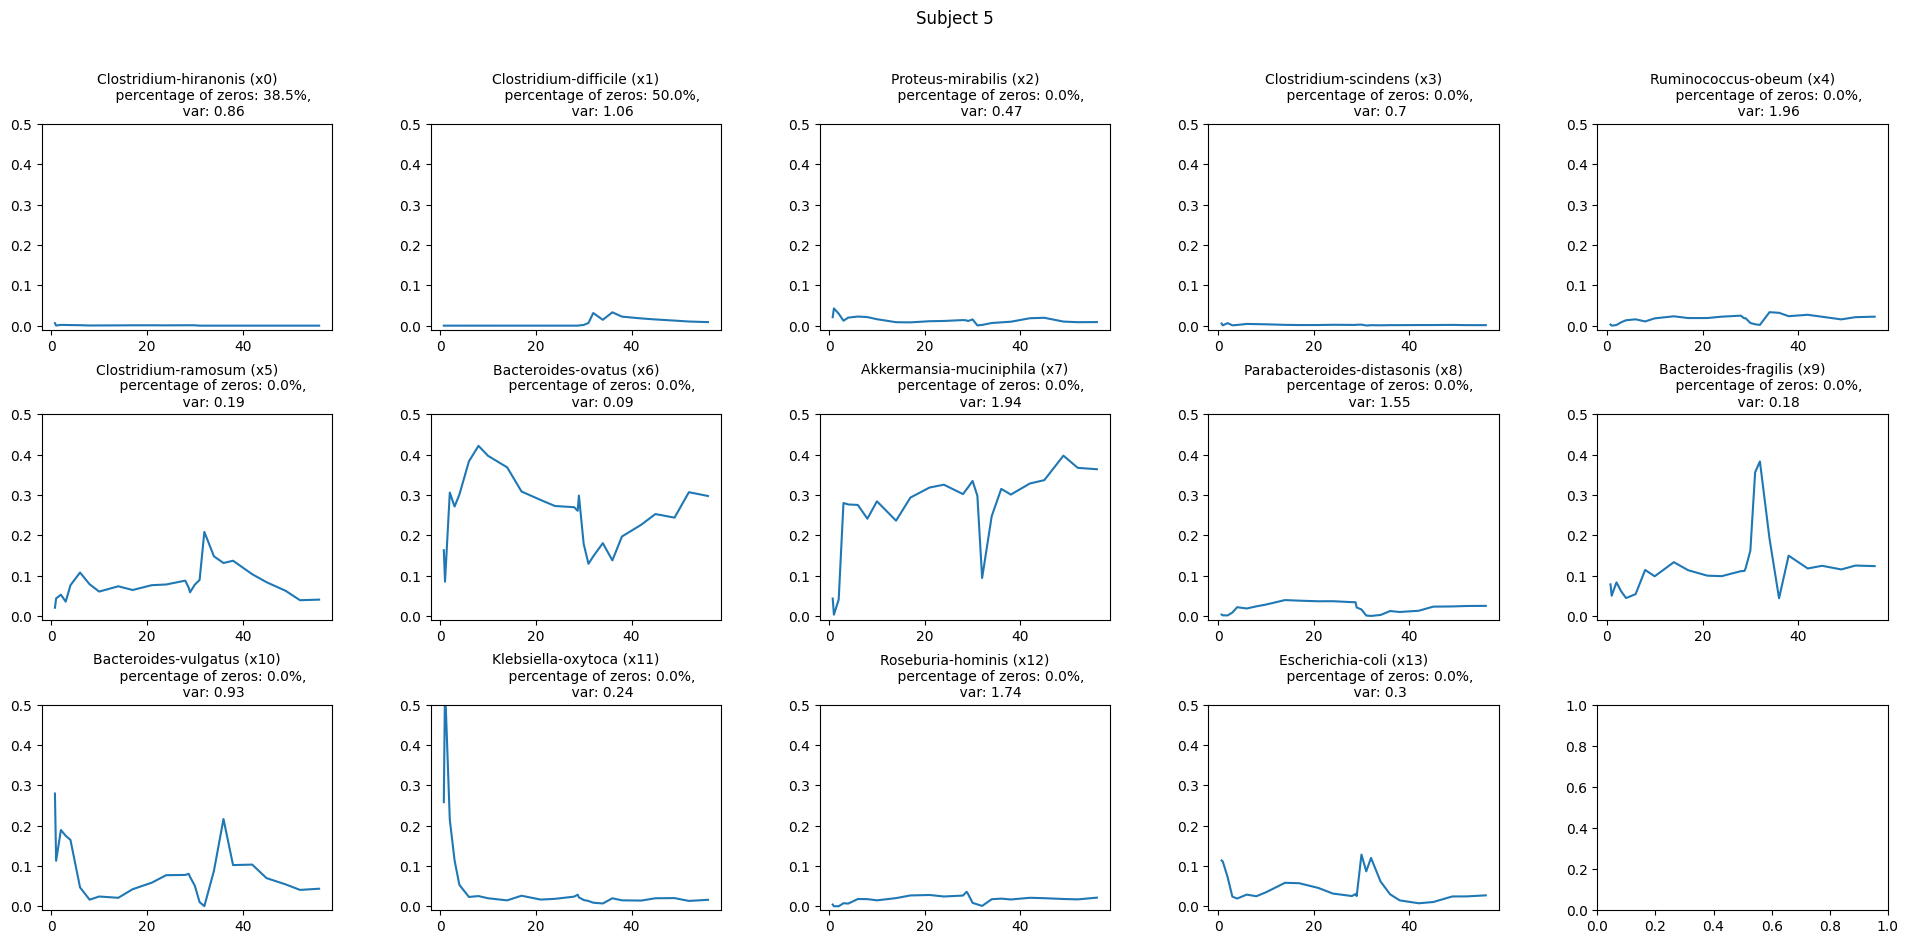

In [12]:
# plot time series for each otu and each subject seperately
n_row = 3
n_col = 5
for sub in np.arange(5):
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    fig.suptitle(f"Subject {sub+1}")
    fig.tight_layout(pad=4.0)
    ind=0
    # for i in taxa_list_mean[1]:
    for i in np.arange(n_taxa):
        # plot each taxon timeline separately
        axs[math.floor(ind/n_col), (ind%n_col)].plot(T[sub], P[sub][:,i])
        axs[math.floor(ind/n_col), (ind%n_col)].set_title(f"""{Names[sub][i]} (x{i})
            percentage of zeros: {round(sum(Y[sub][:,i] == 0)/n_samples*100, 1)}%,
            var: {round(vars[i],2)}""")
        axs[math.floor(ind/n_col), (ind%n_col)].title.set_size(10)
        axs[math.floor(ind/n_col), (ind%n_col)].set_ylim([-0.01, 0.5])
        ind += 1 

### Perform ALR transformation

In [13]:
# # plot data after alr for transformation with every otu as denominator
# for denom_tmp in np.arange(n_taxa):
#     ALR_tmp = construct_alr(P, denom_tmp)
#     # plot alr
#     fig, ax = plt.subplots()
#     for i in np.arange(n_taxa-1):
#         ax.plot(T[0], ALR_tmp[0][:,i]) #, label = f"x{i+1}"
#     # ax.plot(T[0], Y[0][:, denom_tmp], color='black', linewidth=2)
#     # ax.legend()
#     ax.set_title(f"denom is otu {denom_tmp}")

In [14]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = 3
print(denom)

ALR = construct_alr(P, denom)

plot ALR transformed time series with all otus for each subject

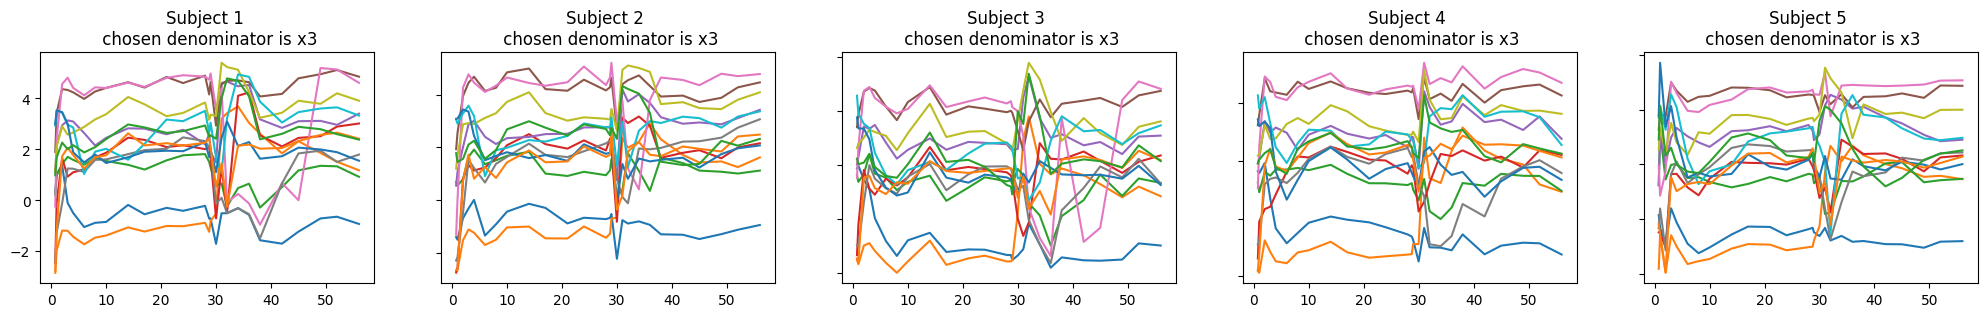

In [16]:
fig, axs = plt.subplots(1, n_subjects)
fig.set_figwidth(25)
fig.set_figheight(3)
for sub in np.arange(n_subjects):
    for i in np.arange(n_taxa-1):
        axs[sub].plot(T[sub], ALR[sub][:,i])
    axs[sub].set_title(f"Subject {sub+1} \n chosen denominator is x{denom}")

for ax in axs.flat:
    ax.label_outer()

plt.show()